### Buidling an Image Classifier Using Sequential API

In [33]:
import tensorflow as tf

In [34]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [35]:
X_train.shape

(55000, 28, 28)

In [36]:
X_train.dtype

dtype('uint8')

For simplicity, we’ll scale the pixel intensities down to the 0–1 range by dividing them by 255.0 (this also converts them to floats):

In [37]:
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

With MNIST, when the label is equal to 5, it means that the image represents the handwritten digit 5. Easy. For Fashion MNIST, however, we need the list of class names to know what we are dealing with:

In [38]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
                   "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [39]:
class_names[y_train[0]]

'Ankle boot'

#### Creating the model using the sequential API

Now let’s build the neural network! Here is a classification MLP with two hidden layers:

In [40]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=[28,28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

Instead of adding the layers one by one as we just did, it’s often more convenient to pass a list of layers when creating the Sequential model. You can also drop the Input layer and instead specify the input_shape in the first layer:

In [41]:
model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(300, activation="relu"),
        tf.keras.layers.Dense(100, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax")
])

The model’s summary() method displays all the model’s layers,14 including each layer’s name (which is automatically generated unless you set it when creating the layer), its output shape (None means the batch size can be anything), and its number of parameters. The summary ends with the total number of parameters, including trainable and non-trainable parameters. Here we only have trainable parameters (you will see some non-trainable parameters later in this chapter):

In [42]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_19 (Dense)            (None, 300)               235500    
                                                                 
 dense_20 (Dense)            (None, 100)               30100     
                                                                 
 dense_21 (Dense)            (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Note that Dense layers often have a lot of parameters. For example, the first hidden layer has 784 × 300 connection weights, plus 300 bias terms, which adds up to 235,500 parameters! This gives the model quite a lot of flexibility to fit the training data, but it also means that the model runs the risk of overfitting, especially when you do not have a lot of training data. We will come back to this later.

Each layer in a model must have a unique name (e.g., "dense_2"). You can set the layer names explicitly using the constructor’s name argument, but generally it’s sim‐ pler to let Keras name the layers automatically, as we just did. Keras takes the layer’s class name and converts it to snake case (e.g., a layer from the MyCoolLayer class is named "my_cool_layer" by default). Keras also ensures that the name is globally unique, even across models, by appending an index if needed, as in "dense_2". But why does it bother making the names unique across models? Well, this makes it possible to merge models easily without getting name conflicts.

You can easily get a model’s list of layers using the layers attribute, or use the get_layer() method to access a layer by name:

In [43]:
model.layers

In [44]:
hidden1 = model.layers[1]
hidden1.name

'dense_19'

In [46]:
model.get_layer('dense_19') is hidden1

True

All the parameters of a layer can be accessed using its get_weights() and set_weights() methods. For a Dense layer, this includes both the connection weights and the bias terms:

In [47]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.01171166, -0.0455946 , -0.06099164, ..., -0.01070148,
        -0.06490641, -0.06298914],
       [-0.01247824, -0.00236209,  0.07235271, ...,  0.0433299 ,
        -0.02734338,  0.04987819],
       [ 0.01917706, -0.02338834,  0.00536769, ..., -0.01429823,
         0.06894374,  0.06259514],
       ...,
       [ 0.02124688, -0.01124633, -0.0061475 , ...,  0.00923929,
        -0.0743577 , -0.036768  ],
       [-0.01719093, -0.07415979,  0.04971988, ..., -0.01528203,
        -0.01632241,  0.06814897],
       [ 0.02364569,  0.06128085, -0.05449406, ..., -0.02653084,
        -0.07317065, -0.06492712]], dtype=float32)

In [48]:
weights.shape

(784, 300)

In [49]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [50]:
biases.shape

(300,)

#### Compiling the model

After a model is created, you must call its compile() method to specify the loss function and the optimizer to use. Optionally, you can specify a list of extra metrics to compute during training and evaluation:

In [51]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

Using loss="sparse_categorical_crossentropy" is the equivalent of using loss=tf.keras.losses.sparse_categorical_ crossentropy. Similarly, using optimizer="sgd" is the equiva‐ lent of using optimizer=tf.keras.optimizers.SGD(), and using metrics=["accuracy"] is the equivalent of using metrics= [tf.keras.metrics.sparse_categorical_accuracy] (when using this loss). We will use many other losses, optimizers, and metrics in this book; for the full lists, see https://keras.io/api/losses, https:// keras.io/api/optimizers, and https://keras.io/api/metrics.

This code requires explanation. We use the "sparse_categorical_crossentropy" loss because we have sparse labels (i.e., for each instance, there is just a target class index, from 0 to 9 in this case), and the classes are exclusive. If instead we had one target probability per class for each instance (such as one-hot vectors, e.g., [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] to represent class 3), then we would need to use the "categorical_crossentropy" loss instead. If we were doing binary classification or multilabel binary classification, then we would use the "sigmoid" activation function in the output layer instead of the "softmax" activation function, and we would use the "binary_crossentropy" loss.

If you want to convert sparse labels (i.e., class indices) to one-hot vector labels, use the tf.keras.utils.to_categorical() func‐ tion. To go the other way round, use the np.argmax() function with axis=1.


Regarding the optimizer, "sgd" means that we will train the model using stochastic gradient descent. In other words, Keras will perform the backpropagation algorithm described earlier (i.e., reverse-mode autodiff plus gradient descent).


When using the SGD optimizer, it is important to tune the learn‐ ing rate. So, you will generally want to use optimizer=tf.keras. optimizers.SGD(learning_rate=__???__) to set the learning rate, rather than optimizer="sgd", which defaults to a learning rate of 0.01.

Finally, since this is a classifier, it’s useful to measure its accuracy during training and evaluation, which is why we set metrics=["accuracy"].

#### Training and evaluating the model

In [52]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7298 - accuracy: 0.7600 - val_loss: 0.5065 - val_accuracy: 0.8304
Epoch 2/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4896 - accuracy: 0.8303 - val_loss: 0.4591 - val_accuracy: 0.8342
Epoch 3/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4423 - accuracy: 0.8453 - val_loss: 0.4238 - val_accuracy: 0.8528
Epoch 4/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.4180 - accuracy: 0.8545 - val_loss: 0.3966 - val_accuracy: 0.8604
Epoch 5/30
1719/1719 [==============================] - 2s 977us/step - loss: 0.3972 - accuracy: 0.8603 - val_loss: 0.3935 - val_accuracy: 0.8602
Epoch 6/30
1719/1719 [==============================] - 2s 979us/step - loss: 0.3814 - accuracy: 0.8661 - val_loss: 0.3965 - val_accuracy: 0.8604
Epoch 7/30
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3691 - accuracy: 0.8693 - val_loss: 0.3741 - val_accur

We pass it the input features (X_train) and the target classes (y_train), as well as the number of epochs to train (or else it would default to just 1, which would definitely not be enough to converge to a good solution). We also pass a validation set (this is optional). Keras will measure the loss and the extra metrics on this set at the end of each epoch, which is very useful to see how well the model really performs. If the performance on the training set is much better than on the validation set, your model is probably overfitting the training set, or there is a bug, such as a data mismatch between the training set and the validation set.

In [53]:
import matplotlib.pyplot as plt
import pandas as pd

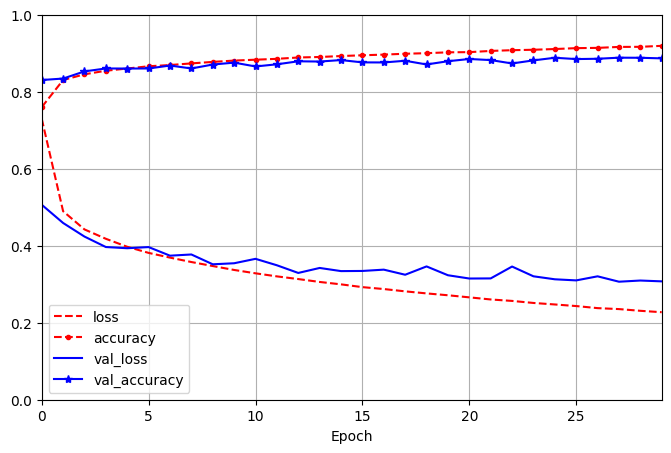

In [54]:
pd.DataFrame(history.history).plot(
    figsize=(8,5), xlim=[0,29], ylim=[0,1], grid=True, xlabel='Epoch',
    style=['r--', 'r--.', 'b-', 'b-*']
)
plt.show()

In [55]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.3296 - accuracy: 0.8831


[0.3295632600784302, 0.8830999732017517]

#### Using the model to make predictions

In [56]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 34ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.98],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

For each instance the model estimates one probability per class, from class 0 to class 9. This is similar to the output of the predict_proba() method in Scikit-Learn classifiers. For example, for the first image it estimates that the probability of class 9 (ankle boot) is 96%, the probability of class 7 (sneaker) is 2%, the probability of class 5 (sandal) is 1%, and the probabilities of the other classes are negligible. In other words, it is highly confident that the first image is footwear, most likely ankle boots but possibly sneakers or sandals. If you only care about the class with the highest estimated probability (even if that probability is quite low), then you can use the argmax() method to get the highest probability class index for each instance:

In [57]:
import numpy as np
y_pred = y_proba.argmax(axis=-1)
y_pred

array([9, 2, 1])

In [58]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [59]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

### Building a Regression MLP Using Sequential API

Let’s switch back to the California housing problem and tackle it using the same MLP as earlier, with 3 hidden layers composed of 50 neurons each, but this time building it with Keras.

Using the sequential API to build, train, evaluate, and use a regression MLP is quite similar to what we did for classification. The main differences in the following code example are the fact that the output layer has a single neuron (since we only want to predict a single value) and it uses no activation function, the loss function is the mean squared error, the metric is the RMSE, and we’re using an Adam optimizer like Scikit-Learn’s MLPRegressor did. Moreover, in this example we don’t need a Flatten layer, and instead we’re using a Normalization layer as the first layer: it does the same thing as Scikit-Learn’s StandardScaler, but it must be fitted to the training data using its adapt() method before you call the model’s fit() method. Let’s take a look:

In [60]:
tf.random.set_seed(42)
norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss='mse', optimizer=optimizer, metrics=['RootMeanSquaredError'])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test, rmse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Epoch 1/20
1719/1719 [==============================] - 3s 2ms/step - loss: 8.5526 - root_mean_squared_error: 2.9245 - val_loss: 8.4127 - val_root_mean_squared_error: 2.9006
Epoch 2/20
1719/1719 [==============================] - 3s 1ms/step - loss: 8.3025 - root_mean_squared_error: 2.8814 - val_loss: 8.3916 - val_root_mean_squared_error: 2.8970
Epoch 3/20
1719/1719 [==============================] - 3s 2ms/step - loss: 8.2867 - root_mean_squared_error: 2.8787 - val_loss: 8.4089 - val_root_mean_squared_error: 2.9000
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 8.2785 - root_mean_squared_error: 2.8772 - val_loss: 8.4471 - val_root_mean_squared_error: 2.9065
Epoch 5/20
1719/1719 [==============================] - 3s 1ms/step - loss: 8.2698 - root_mean_squared_error: 2.8757 - val_loss: 8.3914 - val_root_mean_squared_error: 2.8970
Epoch 6/20
1719/1719 [==============================] - 2s 1ms/step - loss: 8.2596 - root_mean_squared_error: 2.8740 - val_loss: 8

The Normalization layer learns the feature means and standard deviations in the training data when you call the adapt() method. Yet when you display the model’s summary, these statistics are listed as non-trainable. This is because these parameters are not affected by gradient descent.

As you can see, the sequential API is quite clean and straightforward. However, although Sequential models are extremely common, it is sometimes useful to build neural networks with more complex topologies, or with multiple inputs or outputs. For this purpose, Keras offers the functional API.

### Building Complex Models Using the Functional API
## NOT FINISHED

One example of a nonsequential neural network is a Wide & Deep neural network. This neural network architecture was introduced in a 2016 paper by Heng-Tze Cheng et al. It connects all or part of the inputs directly to the output layer. This architecture makes it possible for the neural network to learn both deep patterns (using the deep path) and simple rules (through the short path). In contrast, a regular MLP forces all the data to flow through the full stack of layers; thus, simple patterns in the data may end up being distorted by this sequence of transformations.

Let’s build such a neural network to tackle the California housing problem:

In [61]:
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

Once you have built this Keras model, everything is exactly like earlier, so there’s no need to repeat it here: you compile the model, adapt the Normalization layer, fit the model, evaluate it, and use it to make predictions.

But what if you want to send a subset of the features through the wide path and a different subset (possibly overlapping) through the deep path. In this case, one solution is to use multiple inputs. For example, suppose we want to send five features through the wide path (features 0 to 4), and six features through the deep path (features 2 to 7). We can do this as follows:

In [62]:
input_wide = tf.keras.layers.Input(shape=[5]) # features 0 to 4 
input_deep = tf.keras.layers.Input(shape=[6]) # features 2 to 7 
norm_layer_wide = tf.keras.layers.Normalization() 
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

Now we can compile the model as usual, but when we call the fit() method, instead of passing a single input matrix X_train, we must pass a pair of matrices (X_train_wide, X_train_deep), one per input. The same is true for X_valid, and also for X_test and X_new when you call evaluate() or predict():

In [70]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=1e-3)
model.compile(loss='mse', optimizer=optimizer, metrics=['RootMeanSquaredError'])

X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]

In [81]:
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20,
                    validation_data=((X_valid_wide, X_valid_deep), y_valid))
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

ValueError: in user code:

    File "/Users/robbieardison/anaconda3/envs/tf-pro/lib/python3.11/site-packages/keras/src/engine/base_preprocessing_layer.py", line 123, in adapt_step  *
        self.update_state(data)
    File "/Users/robbieardison/anaconda3/envs/tf-pro/lib/python3.11/site-packages/keras/src/layers/preprocessing/normalization.py", line 319, in update_state  **
        self.adapt_mean * existing_weight + batch_mean * batch_weight

    ValueError: Dimensions must be equal, but are 6 and 4 for '{{node add_1}} = AddV2[T=DT_FLOAT](mul, mul_1)' with input shapes: [6], [4].


### Using the Subclassing API to Build Dynamic Models

Both the sequential API and the functional API are declarative: you start by declaring which layers you want to use and how they should be connected, and only then can you start feeding the model some data for training or inference. This has many advantages: the model can easily be saved, cloned, and shared; its structure can be displayed and analyzed; the framework can infer shapes and check types, so errors can be caught early (i.e., before any data ever goes through the model). It’s also fairly straightforward to debug, since the whole model is a static graph of layers. But the flip side is just that: it’s static. Some models involve loops, varying shapes, conditional branching, and other dynamic behaviors. For such cases, or simply if you prefer a more imperative programming style, the subclassing API is for you.

With this approach, you subclass the Model class, create the layers you need in the constructor, and use them to perform the computations you want in the call() method. For example, creating an instance of the following WideAndDeepModel class gives us an equivalent model to the one we just built with the functional API:

In [82]:
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation) 
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation) 
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)
    
    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2]) 
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

This example looks like the previous one, except we separate the creation of the layers17 in the constructor from their usage in the call() method. And we don’t need to create the Input objects: we can use the input argument to the call() method.

Now that we have a model instance, we can compile it, adapt its normal‐ ization layers (e.g., using model.norm_layer_wide.adapt(...) and model.norm_ layer_deep.adapt(...)), fit it, evaluate it, and use it to make predictions, exactly like we did with the functional API.

The big difference with this API is that you can include pretty much anything you want in the call() method: for loops, if statements, low-level TensorFlow operations—your imagination is the limit. This makes it a great API when experimenting with new ideas, especially for researchers. However, this extra flexibility does come at a cost: your model’s architecture is hidden within the call() method, so Keras cannot easily inspect it; the model cannot be cloned using tf.keras.models.clone_model(); and when you call the summary() method, you only get a list of layers, without any information on how they are connected to each other. Moreover, Keras cannot check types and shapes ahead of time, and it is easier to make mistakes. So unless you really need that extra flexibility, you should probably stick to the sequential API or the functional API


### Saving and Restoring a Model
Saving a trained Keras model is as simple as it gets:

In [83]:
model.save("my_keras_model", save_format="tf")

ValueError: Model <__main__.WideAndDeepModel object at 0x2e08d1950> cannot be saved either because the input shape is not available or because the forward pass of the model is not defined.To define a forward pass, please override `Model.call()`. To specify an input shape, either call `build(input_shape)` directly, or call the model on actual data using `Model()`, `Model.fit()`, or `Model.predict()`. If you have a custom training step, please make sure to invoke the forward pass in train step through `Model.__call__`, i.e. `model(inputs)`, as opposed to `model.call()`.

When you set save_format="tf",18 Keras saves the model using TensorFlow’s Saved‐ Model format: this is a directory (with the given name) containing several files and subdirectories. In particular, the saved_model.pb file contains the model’s architecture and logic in the form of a serialized computation graph, so you don’t need to deploy the model’s source code in order to use it in production; the SavedModel is sufficient. The keras_metadata.pb file contains extra information needed by Keras. The variables subdirectory contains all the parameter values (including the connection weights, the biases, the normalization statistics, and the optimizer’s parameters), possibly split across multiple files if the model is very large. Lastly, the assets directory may contain extra files, such as data samples, feature names, class names, and so on. By default, the assets directory is empty. Since the optimizer is also saved, including its hyperparameters and any state it may have, after loading the model you can continue training if you want.

You will typically have a script that trains a model and saves it, and one or more scripts (or web services) that load the model and use it to evaluate it or to make predictions. Loading the model is just as easy as saving it:

In [85]:
model = tf.keras.models.load_model("my_keras_model")
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

OSError: No file or directory found at my_keras_model

You can also use save_weights() and load_weights() to save and load only the parameter values. This includes the connection weights, biases, preprocessing stats, optimizer state, etc. The parameter values are saved in one or more files such as my_weights.data-00004-of-00052, plus an index file like my_weights.index.

Saving just the weights is faster and uses less disk space than saving the whole model, so it’s perfect to save quick checkpoints during training. If you’re training a big model, and it takes hours or days, then you must save checkpoints regularly in case the computer crashes. But how can you tell the fit() method to save checkpoints? Use callbacks.

### Using Callbacks


The fit() method accepts a callbacks argument that lets you specify a list of objects that Keras will call before and after training, before and after each epoch, and even before and after processing each batch. For example, the ModelCheckpoint callback saves checkpoints of your model at regular intervals during training, by default at the end of each epoch:

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints", 
                                                   save_weights_only=True)

history = model.fit([...], callbacks=[checkpoint_cb])

Moreover, if you use a validation set during training, you can set save_ best_only=True when creating the ModelCheckpoint. In this case, it will only save your model when its performance on the validation set is the best so far. This way, you do not need to worry about training for too long and overfitting the training set: simply restore the last saved model after training, and this will be the best model on the validation set. This is one way to implement early stopping, but it won’t actually stop training.

Another way is to use the EarlyStopping callback. It will interrupt training when it measures no progress on the validation set for a number of epochs (defined by the patience argument), and if you set restore_best_weights=True it will roll back to the best model at the end of training. You can combine both callbacks to save checkpoints of your model in case your computer crashes, and interrupt training early when there is no more progress, to avoid wasting time and resources and to reduce overfitting:

In [ ]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10, 
                                                     restore_best_weights=True)
history = model.fit([...], callbacks=[checkpoint_cb, early_stopping_cb])

The number of epochs can be set to a large value since training will stop automati‐ cally when there is no more progress (just make sure the learning rate is not too small, or else it might keep making slow progress until the end). The EarlyStopping callback will store the weights of the best model in RAM, and it will restore them for you at the end of training.

*Many other callbacks are available in the tf.keras.callbacks package.*

If you need extra control, you can easily write your own custom callbacks. For example, the following custom callback will display the ratio between the validation loss and the training loss during training (e.g., to detect overfitting):

In [86]:
class PrintValTrainRatioCallback(tf.keras.callbacks.Callback): 
      def on_epoch_end(self, epoch, logs):
            ratio = logs["val_loss"] / logs["loss"]
            print(f"Epoch={epoch}, val/train={ratio:.2f}")

As you might expect, you can implement on_train_begin(), on_train_end(), on_epoch_begin(), on_epoch_end(), on_batch_begin(), and on_batch_end(). Call‐ backs can also be used during evaluation and predictions, should you ever need them (e.g., for debugging). For evaluation, you should implement on_test_begin(), on_test_end(), on_test_batch_begin(), or on_test_batch_end(), which are called by evaluate(). For prediction, you should implement on_predict_begin(), on_predict_end(), on_predict_batch_begin(), or on_predict_batch_end(), which are called by predict().

Now let’s take a look at one more tool you should definitely have in your toolbox when using Keras: TensorBoard.

### Using TensorBoard for Visualization